#### The goal is to predict 5 hotel clusters where a user is more likely to stay, out of a total of 100 hotel clusters

In [1]:
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle
import seaborn as sns
import xgboost as xgb

from fancyimpute import SoftImpute
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.externals import joblib
from sklearn.ensemble import RandomForestClassifier
from xgboost.sklearn import XGBClassifier

INPUT_DIR = '/Users/himani/workspace/assignment/pervazive/expedia/input'
MODELS_DIR = '/Users/himani/workspace/assignment/pervazive/expedia/models'
OUTPUT_DIR = '/Users/himani/workspace/assignment/pervazive/expedia/output'
%matplotlib inline

Reading expedia train and test data in separate dataframes
train data contains about 37 million rows and
test data contains about 2.5 million rows.

Code in this file processes training data and create models- Random Forests and xgboost

In [2]:
train_file = os.path.join(INPUT_DIR, 'train_clean1.csv')
test_file = os.path.join(INPUT_DIR, 'test_clean.csv')
destinations_file = os.path.join(INPUT_DIR, 'destinations.csv')

In [3]:
# reading train file and parsing date_time columns to datetime format

train = pd.read_csv(train_file, parse_dates = ['date_time','srch_ci','srch_co'])

In [4]:
# converting srch_ci and srch_co to datetime 

train['srch_ci'] = pd.to_datetime(train['srch_ci'],format='%Y-%m-%d', errors="coerce")
train['srch_co'] = pd.to_datetime(train['srch_co'],format='%Y-%m-%d', errors="coerce")

In [5]:
# for simplification taking only booking data

train = train[train['is_booking'] == 1].reset_index()

In [6]:
#checking missing value percentage in training set

#only orig_destination_distance has missing values

from __future__ import division
length=len(train)
print("Missing values in attributes \n")
for col in train.columns.tolist():
    missing_perc=(train[col].isnull().sum()/length)*100
    print(col+" ------> ",missing_perc)
    

Missing values in attributes 

index ------>  0.0
date_time ------>  0.0
site_name ------>  0.0
posa_continent ------>  0.0
user_location_country ------>  0.0
user_location_region ------>  0.0
user_location_city ------>  0.0
orig_destination_distance ------>  33.831484927
user_id ------>  0.0
is_mobile ------>  0.0
is_package ------>  0.0
channel ------>  0.0
srch_ci ------>  0.0
srch_co ------>  0.0
srch_adults_cnt ------>  0.0
srch_children_cnt ------>  0.0
srch_rm_cnt ------>  0.0
srch_destination_id ------>  0.0
srch_destination_type_id ------>  0.0
is_booking ------>  0.0
cnt ------>  0.0
hotel_continent ------>  0.0
hotel_country ------>  0.0
hotel_market ------>  0.0
hotel_cluster ------>  0.0


## Feature Engineering

creating new features - duration(of stay), month in both test and train

In [7]:
# calculate duration of stay (in days) and creating month

train['duration'] = (train['srch_co'] - train['srch_ci']).dt.days
print("Most frequent duration of stay in training is",train['duration'].mode()[0])

# month
train['month'] = train['srch_ci'].dt.month

Most frequent duration of stay in training is 1


In [8]:
# now deleting date_time, srch_co and srch_ci

train.drop(['srch_co','srch_ci'], inplace = True, axis = 1)

### Replacing missing values in duration with mode & month column with date_time column


In [9]:
train['duration'].fillna(train['duration'].mode()[0], inplace = True)

train['month'].fillna(train['date_time'].dt.month, inplace = True)

train['duration'] = train['duration'].astype(int)

train['month'] = train['month'].astype(int)


### Replacing missing values of orig_destination_distance with matrix completion


In [10]:
df = train.loc[:,['user_location_city','hotel_market','orig_destination_distance']]
df_matrix = df.as_matrix()

#### SoftImpute: Matrix completion by iterative soft thresholding of SVD decompositions.


In [11]:
from fancyimpute import SoftImpute
df_matrix_filled = SoftImpute().complete(df_matrix)

[SoftImpute] Max Singular Value of X_init = 56357176.332212
[SoftImpute] Iter 1: observed MAE=492.036427 rank=2
[SoftImpute] Iter 2: observed MAE=495.486976 rank=2
[SoftImpute] Iter 3: observed MAE=498.157844 rank=2
[SoftImpute] Iter 4: observed MAE=500.170632 rank=2
[SoftImpute] Iter 5: observed MAE=501.658756 rank=2
[SoftImpute] Iter 6: observed MAE=502.749975 rank=2
[SoftImpute] Iter 7: observed MAE=503.550428 rank=2
[SoftImpute] Iter 8: observed MAE=504.142351 rank=2
[SoftImpute] Iter 9: observed MAE=504.582116 rank=2
[SoftImpute] Iter 10: observed MAE=504.911202 rank=2
[SoftImpute] Iter 11: observed MAE=505.157733 rank=2
[SoftImpute] Iter 12: observed MAE=505.343364 rank=2
[SoftImpute] Iter 13: observed MAE=505.484026 rank=2
[SoftImpute] Iter 14: observed MAE=505.590520 rank=2
[SoftImpute] Iter 15: observed MAE=505.671318 rank=2
[SoftImpute] Iter 16: observed MAE=505.732731 rank=2
[SoftImpute] Iter 17: observed MAE=505.779487 rank=2
[SoftImpute] Iter 18: observed MAE=505.815145 ra

In [12]:
# appending filled matrices to respective columns

train['user_location_city'] = pd.Series(df_matrix_filled[:,0])
train['hotel_market'] = pd.Series(df_matrix_filled[:,1])
train['orig_destination_distance'] = pd.Series(df_matrix_filled[:,2])

In [13]:
train.head(3)

,index,date_time,site_name,posa_continent,user_location_country,user_location_region,user_location_city,orig_destination_distance,user_id,is_mobile,...,srch_destination_id,srch_destination_type_id,is_booking,cnt,hotel_continent,hotel_country,hotel_market,hotel_cluster,duration,month
0,1,2014-08-11 08:22:12,2,3,66,348,48862.0,2234.264100,12,0,...,8250,1,1,1,2,50,628.0,1,4,8
1,20,2014-02-27 18:01:32,2,3,66,318,52078.0,2098.097723,756,0,...,8291,1,1,1,2,50,191.0,2,2,4
2,27,2013-06-15 15:38:05,30,4,195,548,56440.0,2271.821667,1048,0,...,1385,1,1,1,0,185,185.0,58,8,9


## Exploratory Analysis

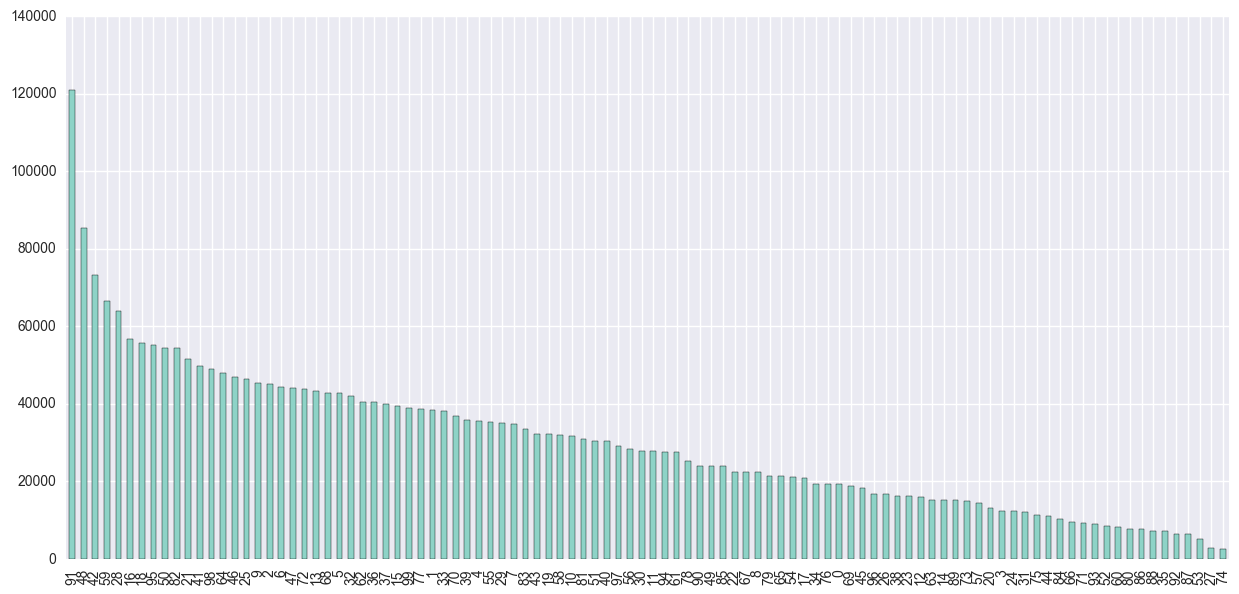

In [14]:
#frequency of each hotel cluster in dataset

fig, ax1 = plt.subplots(1,1, figsize = (15,7))
train["hotel_cluster"].value_counts().plot(kind='bar',colormap="Set3", ax=ax1)
plt.show()

The cluster-wise distribution is not even with certain clusters having more instances in the training data than others.

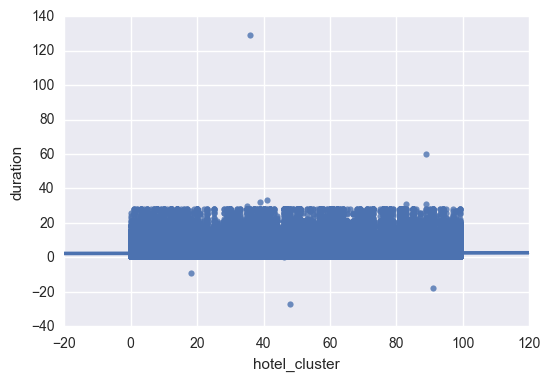

In [15]:
# duration of stay vs hotel cluster

sns.regplot(x = "hotel_cluster",y = 'duration', data = train)
plt.show()

All the clusters seem equally likely when the duration is short, but as the duration increases, certain hotel clusters are preferred over the others. This seems to be a good feature to identify the hotel cluster user would choose.

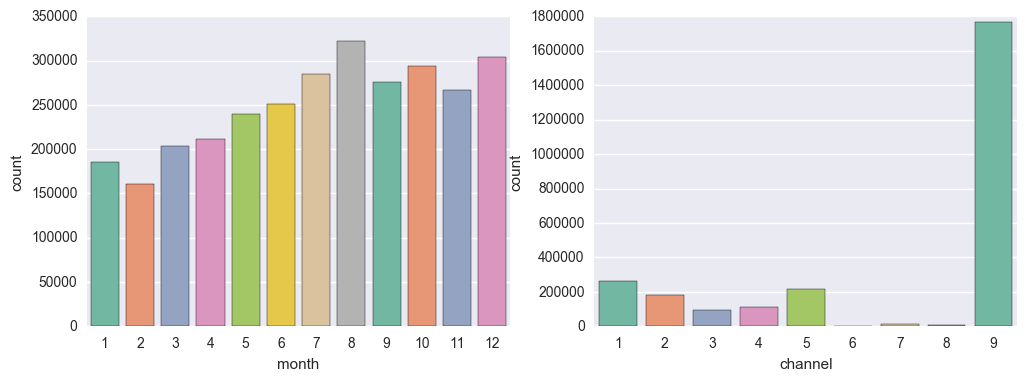

In [16]:
# number of bookings each month and most effective channel

fig, (ax1, ax2) = plt.subplots(1,2, figsize = (12,4))

sns.countplot('month',data = train,order=list(range(1,13)),palette="Set2", ax = ax1)
sns.countplot('channel',data=train,order=list(range(1,10)),palette="Set2", ax = ax2)

It appears most of the booking are made in september and channel 9 appears to be most effective in making the bookings

/usr/local/lib/python3.5/site-packages/seaborn/matrix.py:143: DeprecationWarning: elementwise == comparison failed; this will raise an error in the future.
  if xticklabels == []:
/usr/local/lib/python3.5/site-packages/seaborn/matrix.py:151: DeprecationWarning: elementwise == comparison failed; this will raise an error in the future.
  if yticklabels == []:


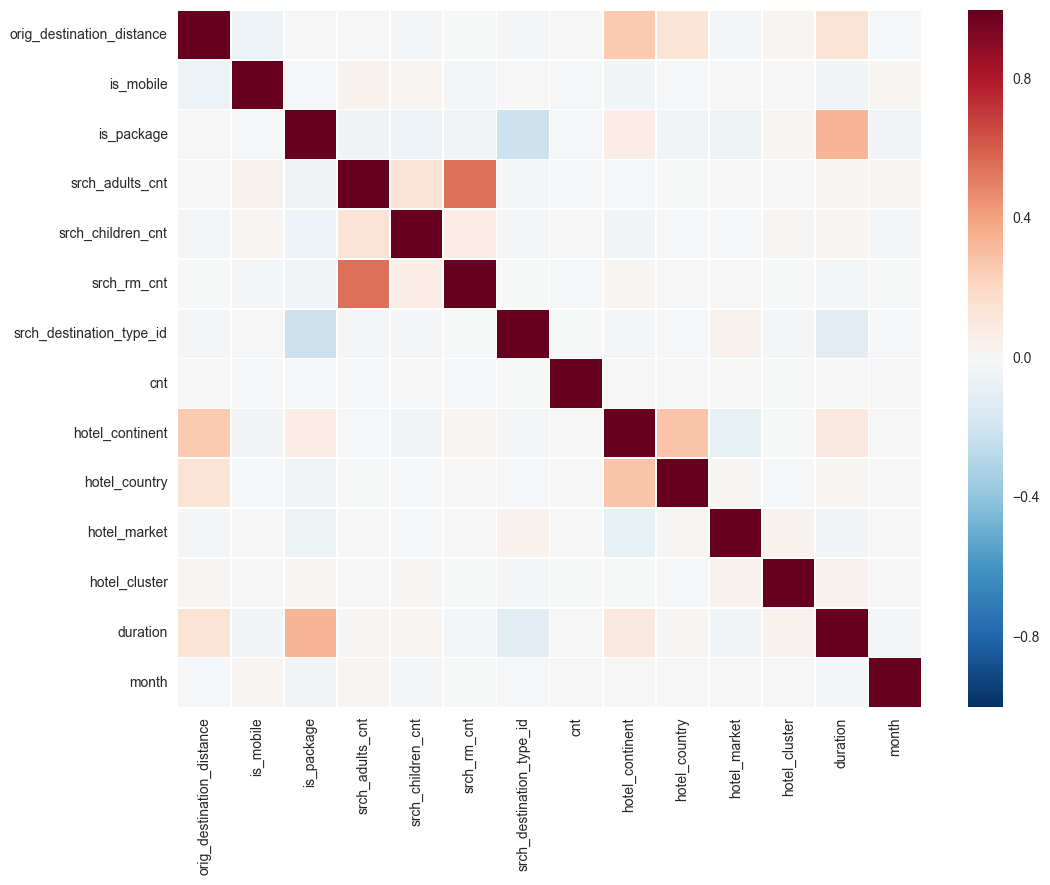

In [21]:
#checking correlation among features of training dataset

fig, (ax1)  = plt.subplots(1,1,figsize=(12,9))
# removing id columns
corr_df = train.drop(['date_time','site_name','posa_continent','user_location_country',
                      'user_location_region','user_location_city','user_id',
                      'channel','srch_destination_id','index','is_booking'], axis =1)

sns.heatmap(corr_df.corr(),annot= False,linewidths= 0.5, vmin = -1, vmax =1)

From correlation matrix, observed following things:
- orig destination distance has a positive correlation with duration which means people who are planning for a long trip tend to go far away from the place of origin.
- duration seems to have a strong positive correlation with is_package. This means that people who tend to book hotel for longer duration usually choose hotels as a part of a package.
- duration is also positively correlated with hotel continent which means certain continents are preferred for longer duration of stay
- srch_rm_cnt has a very strong correlation with srch_adults_cnt and with srch_children_cnt. This is expected as people tend to take rooms based on how many families/couples are there.

/usr/local/lib/python3.5/site-packages/seaborn/categorical.py:342: DeprecationWarning: pandas.core.common.is_categorical_dtype is deprecated. import from the public API: pandas.api.types.is_categorical_dtype instead
  elif is_categorical(y):


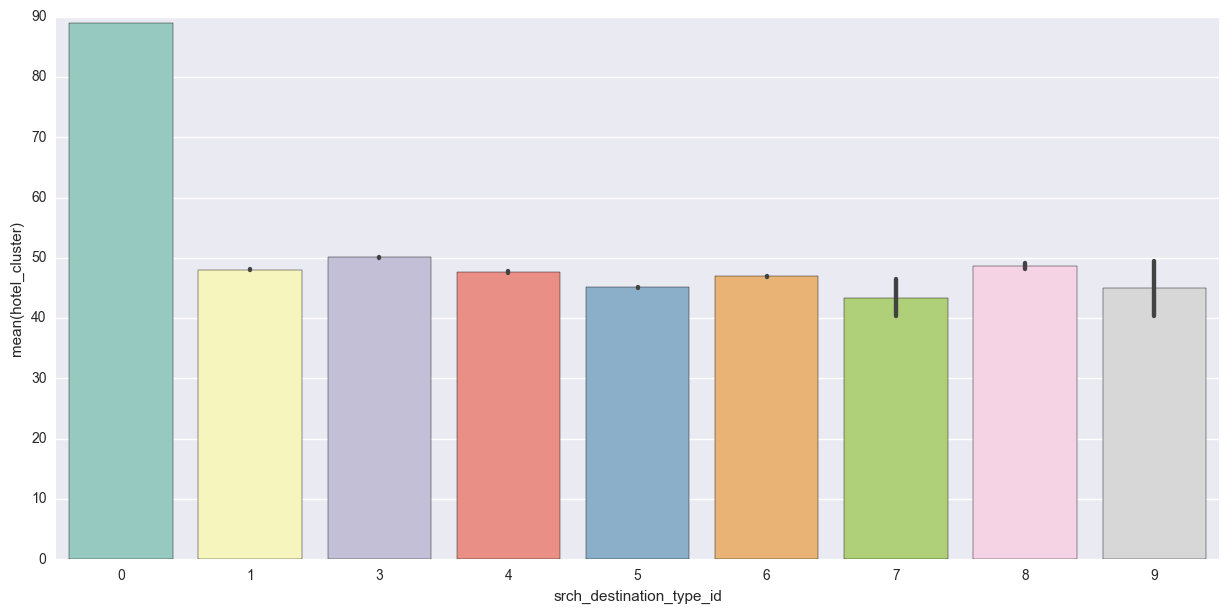

In [22]:
# number of hoter clusters in each destination type id
train['srch_destination_type_id'].unique()

fig, ax1 = plt.subplots(1,1, figsize = (15,7))
# cluster  = train['hotel_cluster'].value_counts()
sns.barplot(x='srch_destination_type_id', y = 'hotel_cluster', data = train, palette = "Set3")
plt.show()

## Understanding  destination file which contains latent features extracted from hotel reviews

In [23]:
destination = pd.read_csv(destinations_file)
print("Number of rows and cols in destination file -",destination.shape)

Number of rows and cols in destination file - (62106, 150)


##### Destination file contains 149 latent features for each destination, need to apply PCA to extract the most relevant dimensions

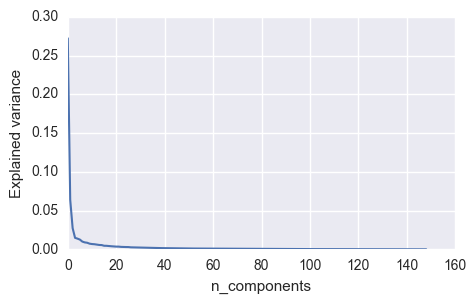

In [24]:
from sklearn.decomposition import PCA 

pca = PCA(n_components=149)
pca.fit_transform(destination[["d{0}".format(i + 1) for i in range(149)]])

fig, ax1 = plt.subplots(1, figsize = (5,3))
plt.clf()
plt.plot(pca.explained_variance_, linewidth=1.5)
plt.xlabel('n_components')
plt.ylabel('Explained variance')

As clear from above figure, we should select the number of component as 20 as variance is not explained much  by further increasing the dimensions. We add these latent features along with our already prepared features.

In [25]:
# creating 20 features from destination file

p = PCA(n_components=20, random_state = 3)
df = p.fit_transform(destination[["d{0}".format(i + 1) for i in range(20)]])
df = pd.DataFrame(df)
df["srch_destination_id"] = destination["srch_destination_id"]
df.head()
col = df.columns.tolist()
col[:-1]

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]

In [26]:
df.shape

(62106, 21)

In [27]:
# append pca features to train data on srch_destination_id using left join

new_train = pd.merge(train, df, on='srch_destination_id', how='left')


In [28]:
# replacing missing values of destination file
# this will be improved by using collaborative filtering to find similar destinations

for i in col[:-1]:
    new_train[i].fillna(new_train[i].mean(), inplace = True)

In [29]:
# saving final train file after processing 

new_train.to_csv(os.path.join(INPUT_DIR, 'train_final.csv'))

In [30]:
# function to calculate mean precision score while doing cross validation on training dataset

def apk(actual, predicted, k=10):
    """
    Computes the average precision at k between two lists of items.
    Parameters
    ----------
    actual : list
             A list of elements that are to be predicted (order doesn't matter)
    predicted : list
                A list of predicted elements (order does matter)
    k : int, optional
        The maximum number of predicted elements
    Returns
    -------
    score : double
            The average precision at k over the input lists
    """
    score = 0.0
    num_hits = 0.0
    if len(predicted)>k:
        predicted = predicted[:k]

    for i,p in enumerate(predicted):
        if p in actual and p not in predicted[:i]:
            num_hits += 1.0
            score += num_hits / (i+1.0)
        if not actual:
            return 0.0
    return score / min(len(actual), k)

def mapk(actual, predicted, k=10):
    """
    Computes the mean average precision at k.
    
    Parameters
    ----------
    actual : list
             A list of lists of elements that are to be predicted 
             (order doesn't matter in the lists)
    predicted : list
                A list of lists of predicted elements
                (order matters in the lists)
    k : int, optional
        The maximum number of predicted elements
    Returns
    -------
    score : double
            The mean average precision at k over the input lists
    """
    return np.mean([apk(a,p,k) for a,p in zip(actual, predicted)])

# Creating Model

## 1) Random Forests

Commented code below is while testing the model using cross validation

In [ ]:
# 1) splitting training data on time

# tr = new_train.loc[new_train["date_time"].dt.year == 2013]
# ts = new_train.loc[new_train["date_time"].dt.year == 2014]
# predictors = [c for c in new_train.columns if c not in ["hotel_cluster","date_time"]]

# X = tr[predictors]
# y = tr['hotel_cluster']
# # x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=3)

# rfc = RandomForestClassifier(n_estimators=100,max_depth=5, min_weight_fraction_leaf=0.1,
#                              random_state=3)
# rfc.fit(X,y)

# # calculate probablities for each class

# predicted_prob = rfc.predict_proba(ts[predictors])

# #creating dataframe of predicted probabilities
# predictions_df = pd.DataFrame(predicted_prob)


In [31]:
# For predictions on kaggle
# training data using random forests

predictors = [c for c in new_train.columns if c not in ['index','cnt','user_id','is_booking',
                                                        "hotel_cluster","date_time"]]

X = new_train[predictors]
y = new_train['hotel_cluster']
# x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=3)

rfc = RandomForestClassifier(n_estimators=1000,max_depth=5, min_weight_fraction_leaf=0.1,
                             n_jobs = -1, random_state=3)



In [ ]:
# fitting data to random forest model

rfc.fit(X,y)

In [ ]:
# saving model to file

joblib.dump(rfc, 'model3.pkl')

In [ ]:
rf_models_file = os.path.join(MODELS_DIR, 'model3.pkl')

### XGBoost algorithm

In [ ]:
# training xgboost

predictors = [c for c in new_train.columns if c not in ['cnt','user_id','is_booking',
                                                        "hotel_cluster","date_time",'index']]

X = new_train[predictors]
y = new_train['hotel_cluster']

clf = XGBClassifier(learning_rate =0.1,n_estimators=1000,max_depth=5,min_child_weight=1,gamma=0,subsample=0.8,
                    colsample_bytree=0.8, objective= 'multi:softprob',scale_pos_weight=1,random_state=3, n_jobs=-1)

In [ ]:
# fitting data to xgboost

clf.fit(X,y)

In [ ]:
# saving model to file

joblib.dump(clf, 'model4.pkl')

In [ ]:
xg_models_file = os.path.join(MODELS_DIR, 'model4.pkl')